<a href="https://colab.research.google.com/github/1kaiser/test2023/blob/main/FloPy_MF2005_%26_MT3D_USGS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/modflowpy/pymake.git@90bcc5d48c758b73c10798968bda6b07ccec0009
!pip install flopy

  Cloning https://github.com/modflowpy/pymake.git (to revision 90bcc5d48c758b73c10798968bda6b07ccec0009) to /tmp/pip-req-build-pat19qxl
  Running command git clone -q https://github.com/modflowpy/pymake.git /tmp/pip-req-build-pat19qxl
  Running command git checkout -q 90bcc5d48c758b73c10798968bda6b07ccec0009
  Created wheel for pymake: filename=pymake-1.1.0-cp36-none-any.whl size=37977 sha256=1e11d8a44c4d7e10da48591a050fdf98adccec7133741eb92b23431c335faed9
  Stored in directory: /tmp/pip-ephem-wheel-cache-m7r16232/wheels/a1/9e/1e/4ddf1f20112cfb30b7e39cd555ee92ebe477459ef60590350e
Successfully built pymake
     |████████████████████████████████| 1.2MB 5.2MB/s 
  Created wheel for flopy: filename=flopy-3.3.2-cp36-none-any.whl size=1181950 sha256=e84a0e98932207f22f014e1fb14220a2dabbe3ec82ae401ec78545c3bdaf66e4
  Stored in directory: /root/.cache/pip/wheels/be/58/09/9cc9394b0c141c09d5d5ca058acf9b70765951e866aa3444bd
Successfully built flopy


In [ ]:
import pymake
pymake.build_apps('mt3dusgs')
pymake.build_apps('mf2005')

mt3dusgs will be built for the "linux" operating system

mt3dusgs will be placed in the directory:
    "."

mt3dusgs will be built using "single" precision floats.

mt3dusgs will be built as a "release" application.

mt3dusgs fortran code will be built with "gfortran".
mt3dusgs c/c++ code will be built with "gcc".

mt3dusgs will use the following predefined syslibs:
    -lc

mt3dusgs will be built for "intel64" architecture.

downloading file:         True
verified download:        True
download timeout:         30 sec.
cleaning extracted files: True

extra files are not being read

Attempting to download the file:
    https://water.usgs.gov/water-resources/software/MT3D-USGS/mt3dusgs1.0.1.zip
 download attempt: 1
   file size: 12,098,547 bytes
     downloaded    204,800 bytes of 12,098,547 bytes (   1.6928%)
     downloaded    409,600 bytes of 12,098,547 bytes (   3.3855%)
     downloaded    614,400 bytes of 12,098,547 bytes (   5.0783%)
     downloaded    819,200 bytes of 12,098,547 

0

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

In [ ]:
workspace = '/content/mf05-mt-ex9-heat'
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [ ]:
!realpath mf2005

/content/mf2005


In [ ]:
# name
modelname = 'mf-ex9-heat'

# exe name
exe_mf2005 = '/content/mf2005'

mf_model = flopy.modflow.Modflow(
    modelname=modelname, 
    exe_name=exe_mf2005,
    model_ws=workspace
)

In [ ]:
Lx = 1600
Ly = 2000
nlay = 1
nrow = 40
ncol = 32
delr = Lx / ncol
delc = Ly / nrow
delv = 10
prsity = 0.3
#perlen = 365*10 # no. days * years

#perlen_mf = 1.
perlen_mf = 365*6  # perlen_mt 
laytyp = 0
k1 = 1.474e-4
k2 = 1.474e-7

In [ ]:
#DIS file
dis = flopy.modflow.ModflowDis(
    model=mf_model, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr, 
    delc=delc, 
    top=0., 
    botm=[0 - delv],
    perlen=perlen_mf,
    xul=0,
    yul=0,    
)

In [ ]:
# ibound array definition
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1

In [ ]:
# start array definition
strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
head_top = 250
head_bottom = 240
strt[0, 0, :] = head_top
strt[0, -1, :] = head_bottom

In [ ]:
# hydraulic conductivity array definition
hk = k1 * np.ones((nlay, nrow, ncol), dtype=np.float)
hk[:, 10:17, 5:18] = k2

In [ ]:
# well space definition
injection_rate = 5000  # m3/d injection / 86400  # 5000  # m3/d injection 
extraction_rate = -1000 # m3/d extraction, set to m3/s to get normal head values. But then the flow transport gets wrong. / 86400  # -1000  # m3/d extraction
welspd = [
    [0, 9, 15, injection_rate],  # injection well
    [0, 24, 15, extraction_rate]  # extraction well
]
# well space array definition (for visz purposes only)
ws = np.empty((nlay, nrow, ncol), dtype=np.float)
ws[:] = np.NaN
for w in welspd:
    ws[w[0], w[1], w[2]] = w[3]

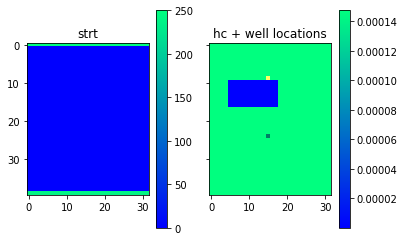

In [ ]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, sharey=True)

im1 = ax1.imshow(strt[0], cmap='winter')
ax1.set_title('strt')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(hk[0], cmap='winter')
plt.colorbar(im2, ax=ax2)
im3 = ax2.imshow(ws[0], cmap='summer')

ax2.set_title('hc + well locations')

plt.show() 

In [ ]:
# prepare the modflow modules
oc = flopy.modflow.ModflowOc(model=mf_model)
bas = flopy.modflow.ModflowBas(model=mf_model, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(model=mf_model, hk=hk, laytyp=laytyp)
wel = flopy.modflow.ModflowWel(model=mf_model, stress_period_data=welspd)
pcg = flopy.modflow.ModflowPcg(model=mf_model)
lmt = flopy.modflow.ModflowLmt(model=mf_model, output_file_name=f'{workspace}/mt3d_link.ftl')
mf_model.write_input()
mf_model.run_model(silent=False)

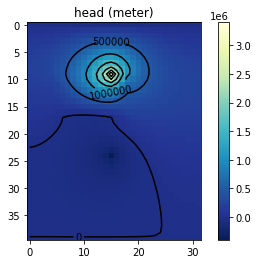

In [ ]:
# plot model results
import flopy.utils.binaryfile as bf

# create the headfile object
headfile = f'{modelname}.hds'
fname = os.path.join(workspace, headfile)
headobj = flopy.utils.binaryfile.HeadFile(fname)
head = headobj.get_data(totim=perlen_mf)
times = headobj.get_times()

# Make the plots
plt.subplot(1, 1, 1, aspect='equal')
plt.title('head (meter)')
plt.imshow(head[0, :, :], cmap='YlGnBu_r')
plt.colorbar()

contours = plt.contour(head[0, :, :], zorder=10, colors='black')
plt.clabel(contours, inline=1, fontsize=10, fmt='%d')

plt.show()

In [ ]:
!realpath mt3dusgs

/content/mt3dusgs


In [ ]:
# name
name_mt3d = 'mt-ex9-heat'

# exe name
exe_mt3dusgs = '/content/mt3dusgs'

In [ ]:
mt_model = flopy.mt3d.Mt3dms(
    modelname=name_mt3d, 
    model_ws=workspace, 
    exe_name=exe_mt3dusgs, 
    modflowmodel=mf_model
)

In [ ]:
sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
sconc[:] = 278

timprs = np.linspace(25, 2500, 100)
btn = flopy.mt3d.Mt3dBtn(
    model=mt_model, 
    sconc=sconc, 
    prsity=0.3, 
    thkmin=0.01, 
    munit='Kelvin', 
    species_names=['warm water'],
    timprs=timprs,
    nprs=len(timprs)
)

In [ ]:
#ADV file
mixelm = -1  # Third-order TVD scheme (ULTIMATE)
percel = 1  # Courant number PERCEL is also a stability constraint
adv = flopy.mt3d.Mt3dAdv(
    model=mt_model, 
    mixelm=mixelm, 
    percel=percel
)

In [ ]:
rct = flopy.mt3d.Mt3dRct(
    model=mt_model,
    isothm=1,
    rhob=1961.0,
    sp1=0.00021,
    igetsc=0
)

In [ ]:
#DSP file
al = 0.5  # longitudinal dispersivity
dmcoef = 1.86e-6  # from videol. In tutorial is the value: 2.15e-11  # effective molecular diffusion coefficient
trpt = 0.1  # ratio of the horizontal transverse dispersivity to the longitudinal dispersivity
trpv = 0.1  # ratio of the vertical transverse dispersivity to the longitudinal dispersivity

dsp = flopy.mt3d.Mt3dDsp(
    model=mt_model, 
    al=al, 
    dmcoef=dmcoef, 
    trpt=trpt, 
    trpv=trpv
)

In [ ]:
#SSM file
itype = flopy.mt3d.Mt3dSsm.itype_dict()
print(itype)

ssm_data = {}
for i in range(ncol):
    ssm_data[i] = [(0, 0, i, 278, itype['CHD'])]
for i in range(ncol):
    ssm_data[i+ncol] = [(0, nrow, i, 278, itype['CHD'])]  # 278 Kelvin == 5 Celsius
ssm_data[ncol+ncol] = [(0, 9, 15, 298, itype['WEL'])] # 298 Kelvin == 25 Celsius
ssm = flopy.mt3d.Mt3dSsm(model=mt_model, stress_period_data=ssm_data)

{'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}


In [ ]:
#GCG file
mxiter = 1  # Maximum number of outer iterations
iter1 = 200  # Maximum number of inner iterations
isolve = 3  # Preconditioner = Modified Incomplete Cholesky
gcg = flopy.mt3d.Mt3dGcg(
    model=mt_model, 
    mxiter=mxiter, 
    iter1=iter1, 
    isolve=isolve
)
mt_model.write_input()

In [ ]:
fname = os.path.join(workspace, 'MT3D001.UCN')
if os.path.isfile(fname):
    os.remove(fname)
mt_model.run_model(silent=False)

In [ ]:
fname = os.path.join(workspace, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_alldata()

fname = os.path.join(workspace, 'MT3D001.OBS')
if os.path.isfile(fname):
    cvt = mt_model.load_obs(fname)
else:
    cvt = None

fname = os.path.join(workspace, 'MT3D001.MAS')
mvt = mt_model.load_mas(fname)

In [ ]:
print(fname)

/content/mf05-mt-ex9-heat/MT3D001.MAS


In [ ]:
slice_no = np.linspace(0,conc.shape[0]-1,4).astype(int)
slice_no

array([ 0, 29, 58, 87])

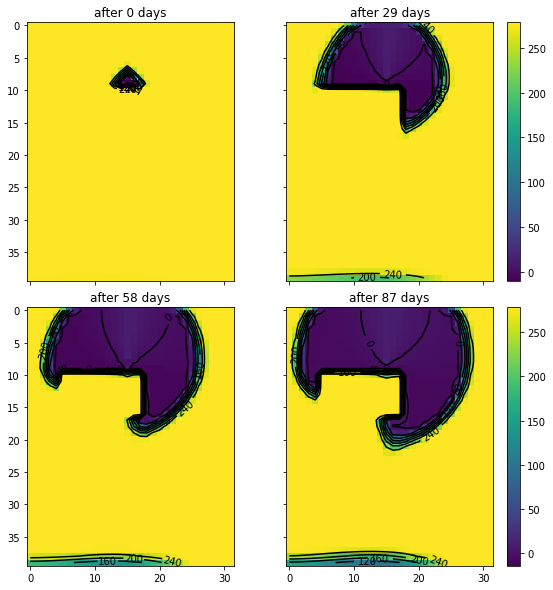

In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, 
    ncols=2, 
    sharex=True, 
    sharey=True,
    figsize=(10,10), gridspec_kw={'hspace': 0.1, 'wspace': 0}
)
# axis 1 
im1 = ax1.imshow(conc[slice_no[0], 0, :, :])#, vmin=277, vmax=300)
#plt.colorbar(im1, ax=ax1)

ct1 = ax1.contour(conc[slice_no[0], 0, :, :], zorder=10, colors='black')
plt.clabel(ct1, inline=1, fontsize=10, fmt='%d')
ax1.set_title(f'after {int(slice_no[0])} days')

# axis 2
im2 = ax2.imshow(conc[slice_no[1], 0, :, :])#, vmin=277, vmax=300)
plt.colorbar(im2, ax=ax2)
ax2.set_title(f'after {int(slice_no[1])} days')

ct2 = ax2.contour(conc[slice_no[1], 0, :, :], zorder=10, colors='black')
plt.clabel(ct2, inline=1, fontsize=10, fmt='%d')

# axis 3
im3 = ax3.imshow(conc[slice_no[2], 0, :, :])#, vmin=277, vmax=300)
#plt.colorbar(im3, ax=ax3)
ax3.set_title(f'after {int(slice_no[2])} days')

ct3 = ax3.contour(conc[slice_no[2], 0, :, :], zorder=10, colors='black')
plt.clabel(ct3, inline=1, fontsize=10, fmt='%d')

# axis 4
im4 = ax4.imshow(conc[slice_no[3], 0, :, :])#, vmin=277, vmax=300)
plt.colorbar(im4, ax=ax4)
ax4.set_title(f'after {int(slice_no[3])} days')

ct4 = ax4.contour(conc[slice_no[3], 0, :, :], zorder=10, colors='black')
plt.clabel(ct4, inline=1, fontsize=10, fmt='%d')

plt.show()